<a href="https://colab.research.google.com/github/k18a/AdsorptionLabview/blob/master/Attention_nBodyProblems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')


# Capturing AI’s Attention: Physics of Repetition, Hallucination, Bias and Beyond - Notebook

This notebook is for learning the following paper:

https://arxiv.org/html/2504.04600v1


## Transformer Attention is a 2 Body System

Let's start with word embeddings:

Each token $t$ is a row-vector $s_t \in \mathbb{R}^d$.

Linear projections A single-head self-attention layer has weight matrices:

$$
Q, K, V \in \mathbb{R}^{d \times d}
$$


The projected "query" and "key" for an input token $s_i$ are:

$$
\boldsymbol{q}_i=s_i Q, \quad k_i=s_i K
$$

Attention weights (before Softmax) for an ordered pair of tokens $i, j$ are the scaled dot product:

$$
a_{i j}=\frac{q_i \cdot k_j^{\top}}{\sqrt{d}} .
$$

Now we bring in physics:

Set

$\beta=1 / T$

Define

$$
H_2\left(s_i, s_j\right)=-\frac{1}{\sqrt{d}} q_i \cdot k_j^{\top} .
$$


Then the raw attention score becomes

$$
a_{i j}=-\beta H_2\left(s_i, s_j\right)
$$

This is the interaction of two classical spins

Now we bring in Boltzmann distribution aka Softmax

$$
A_{i j}=\operatorname{softmax}_j\left(a_{i j}\right)=\frac{\exp \left(-\beta H_2\left(s_i, s_j\right)\right)}{\sum_{j^{\prime}} \exp \left(-\beta H_2\left(s_i, s_{j^{\prime}}\right)\right)}
$$

Key take aways:

- Teh query and key projections resemble solid state spins
- Alignment between spins and attention probability are correlated
- The model picking the next token is similar to selecting the minimum energy configuration of a 2-spin system

Let's confirm this below:

In [ ]:
# make sample embeddings
tokens = ['A', 'B', 'C', 'D']
d = 2  # embedding dimension for plotting
embeddings = {
    'A': np.array([1.0, 0.0]),
    'B': np.array([0.0, 1.0]),
    'C': np.array([1.0, 1.0]),
    'D': np.array([-1.0, 0.0])
}

# in real transformers these would be different, but this is just for testing
Q = np.eye(d)
K = np.eye(d)

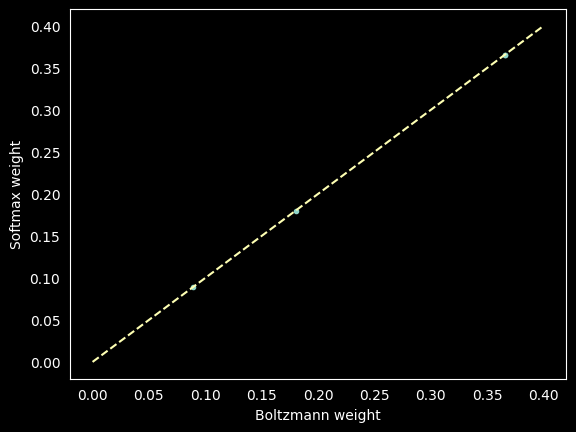

In [ ]:
def attention_row(query_token):
    q = embeddings[query_token] @ Q
    energies = []
    for t in tokens:
        k = embeddings[t] @ K
        energy = -np.dot(q, k) / np.sqrt(d)  # Eq (1) energy with minus sign
        energies.append(energy)
    energies = np.array(energies)
    # Boltzmann weights beta=1
    boltz = np.exp(-energies)
    boltz /= boltz.sum()
    # Softmax over raw dot products (without minus sign)
    logits = np.array([np.dot(embeddings[query_token], embeddings[t]) / np.sqrt(d) for t in tokens])
    softmax = np.exp(logits) / np.exp(logits).sum()

    return energies, boltz, softmax

energies, boltz, softmax = attention_row('A')

df = pd.DataFrame({
    'Token j': tokens,
    'Energy H2(sA,sj)': energies,
    'Boltzmann weight': boltz,
    'Softmax weight': softmax
})

plt.plot(df['Boltzmann weight'],df['Softmax weight'],'.')
plt.plot(np.linspace(0,.4),np.linspace(0,.4),'--')
plt.xlabel('Boltzmann weight')
plt.ylabel('Softmax weight')
plt.show()

As expected the two probabilities match perfectly!

In [ ]:
# Another useful function for attention matrix instead of row
def attention_matrix(bias=None,tau=1.0):
    """Return attention matrix with optional bias field (dict token -> delta_energy)."""
    n = len(tokens)
    attn = np.zeros((n, n))
    for i, qi in enumerate(tokens):
        # projected query
        q = embeddings[qi] @ Q
        logits = []
        for tj in tokens:
            k = embeddings[tj] @ K
            # base dot product scaled
            base = np.dot(q, k) / np.sqrt(d)
            # convert to energy then apply bias: energy = -base - bias
            delta = bias.get(tj, 0.0) if bias else 0.0
            energy = base + delta
            # convert back to logit for softmax: logit = -energy
            logits.append(energy)
        logits = np.array(logits) / tau
        attn[i] = np.exp(logits) / np.exp(logits).sum()
    return attn

# Function used for plotting colour maps
def plot_heatmap(ax, attn, title, max_value):
  """
  Plot attention matrix as heatmap.
  """
  im = ax.imshow(attn, vmax=max_value)
  ax.set_xticks(range(len(tokens)), tokens)
  ax.set_yticks(range(len(tokens)), tokens)
  ax.set_title(title)
  return im


## Phase Shift (Fine Tuning / Prompt Engineering / RLHF) is Bias Field

Let's add an external bias field to attention mechanism term for B (other embeddings are constant):

$H_2^{\prime}\left(s_i, s_j\right)=H_2\left(s_i, s_j\right)-h_j$

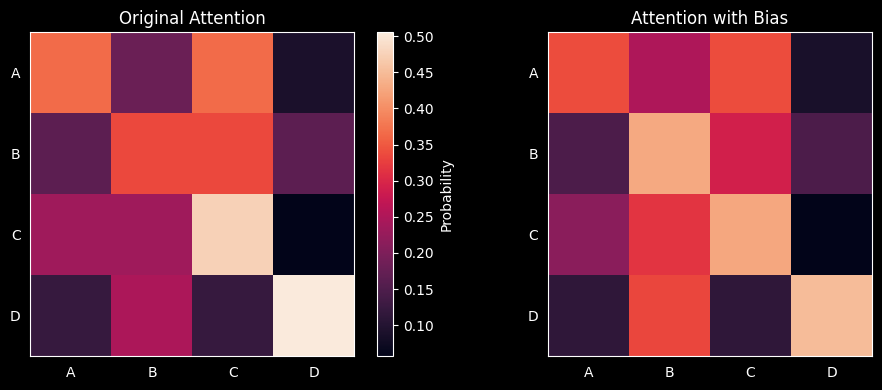

In [ ]:
# Define bias field: give token B a -0.4 energy shift (makes it more likely)
bias_field = {'B': 0.4}  # positive delta lowers energy by 0.4
mats = [attention_matrix(),
        attention_matrix(bias=bias_field)]
max_value = max(mat.max() for mat in mats)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im1 = plot_heatmap(axes[0], attention_matrix(), title="Original Attention",max_value=max_value)
im2 = plot_heatmap(axes[1], attention_matrix(bias=bias_field), title="Attention with Bias",max_value=max_value)

fig.colorbar(im1, ax=axes[0], label="Probability")

plt.tight_layout()
plt.show()


There seems to be some self-attention as we generated both projection matrices from same tokens.

Without bias field:
- C seems to be closer to other embeddings (evident from how we set it up).
- D has the highest self attention as it has very different embeddings from others (nothing in key embeddings come close)

With bias field:
- B is much more common everywhere

Key take away: adding additional energy terms is a simple way of slightly modifying Q, K, V matrices (done in practice through techniques like fine tuning, prompt engineering, few shot learning, etc.)

The paper uses the term phase shift - the pointwehre energy tipping causes model to flip from one dominant token to another.

Point to remember: more thorough fine tuning could correspond to modifying more parameters also - not just adding a parameter, but the assumption holds for small changes (I think).

## Temperature (Physics) is Temperature (Computer Science)

From before:

$$
A_{i j}=\frac{\exp \left(-E_j / k T\right)}{\sum_{j^{\prime}} \exp \left(-E_{j^{\prime}} / k T\right)}
=\frac{\exp \left(s_j / \tau\right)}{\sum_{j^{\prime}} \exp \left(s_{j^{\prime}} / \tau\right)}
$$

(Physics vs Computer Science)

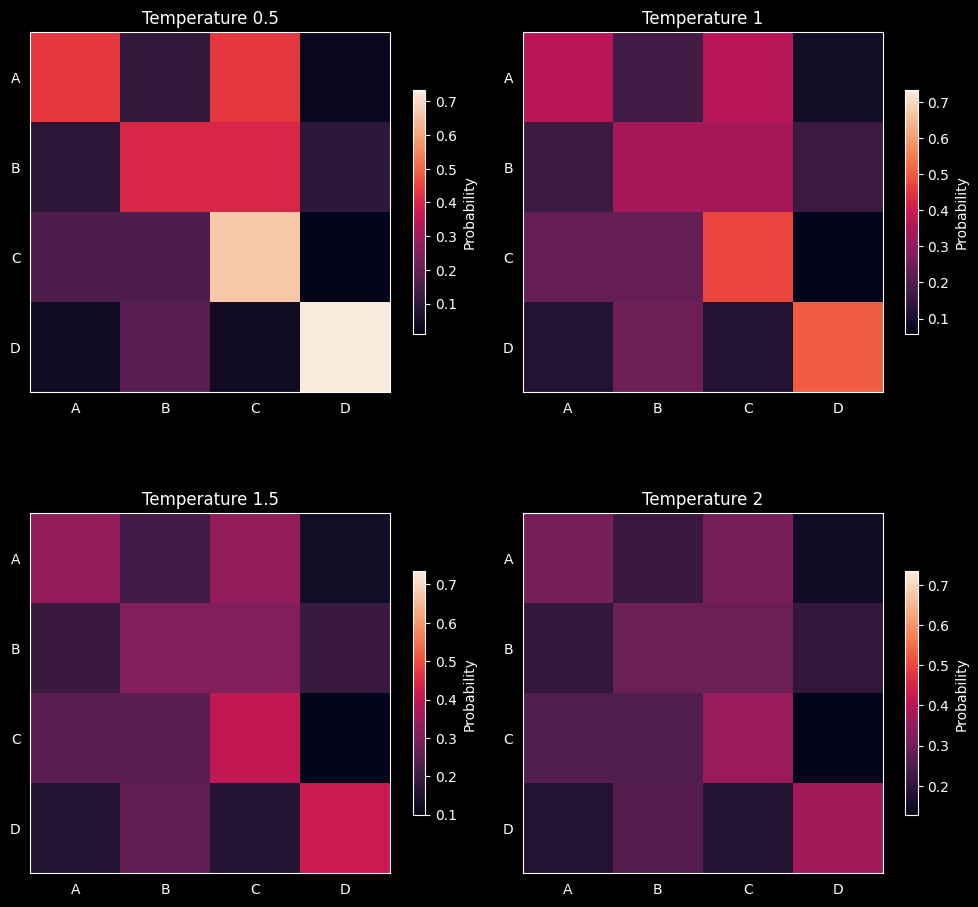

In [ ]:
tau = [0.5, 1, 1.5, 2]
mats = [attention_matrix(tau=t) for t in tau]
max_value = max(mat.max() for mat in mats)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, mat in enumerate(mats):
    im = plot_heatmap(axes[i // 2, i % 2], mat, title=f"Temperature {tau[i]}",max_value=max_value)
    fig.colorbar(im, ax=axes[i // 2, i % 2], label="Probability", location = 'right',shrink=0.5)
plt.tight_layout()
plt.show()

As we increase temperature, we can see energy is increases by exp(-E/T) - probability distribution flatens. The LLM response is more unpredictable.

<ipython-input-186-8b6c8cbbb597>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_colors)  # Get a colormap with enough colors
<ipython-input-186-8b6c8cbbb597>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_colors)


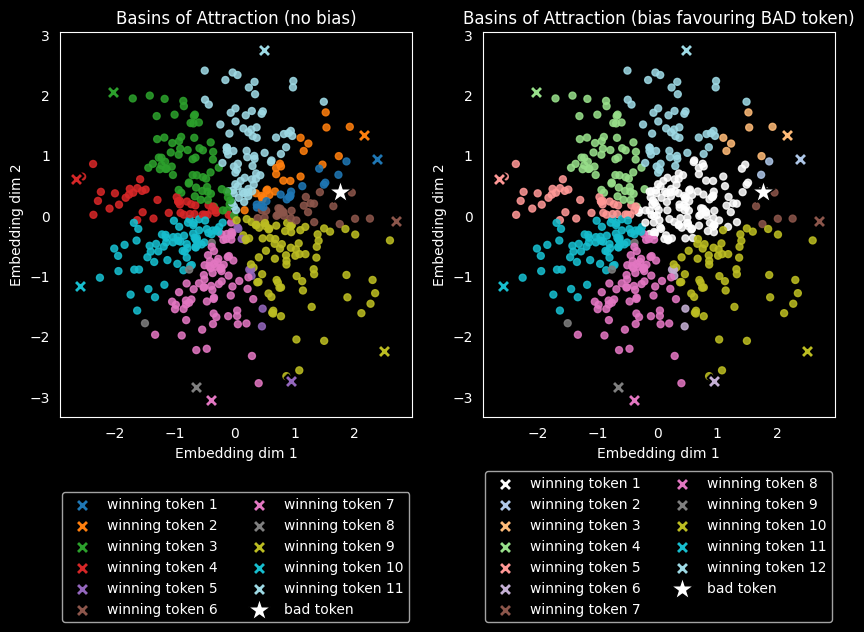

In [ ]:
np.random.seed(0)
num_tokens = 500
d = 2
embeddings = np.random.randn(num_tokens, d)

def get_winners(embeds, tau=1.0, bias=0):
    n = embeds.shape[0]
    winners = np.zeros(n, dtype=int)
    for i in range(n):
        logits = embeds[i] @ embeds.T # dot product with all tokens
        logits *= 1/np.sqrt(d) # scale by sqrt(d)
        logits += bias # energy term
        logits /= tau # temperature term
        winners[i] = logits.argmax() # winner key
    return winners

winners_no_bias = get_winners(embeddings)

bad_token = 0
bias_vector = np.zeros(num_tokens)
bias_strength = 1.0
bias_vector[bad_token] = bias_strength
winners_bias = get_winners(embeddings, bias=bias_vector)

# Generate unique colors for each winning token
unique_winners_no_bias = np.unique(winners_no_bias)
num_colors = len(unique_winners_no_bias)
cmap = plt.cm.get_cmap('tab20', num_colors)  # Get a colormap with enough colors
colors_no_bias = [cmap(i) for i in range(num_colors)]
unique_winners_bias = np.unique(winners_bias)
num_colors = len(unique_winners_bias)
cmap = plt.cm.get_cmap('tab20', num_colors)
colors_bias = [cmap(i) for i in range(num_colors)]
# Create a dictionary mapping winning tokens to colors for no bias
color_dict_no_bias = {winner: color for winner, color in zip(unique_winners_no_bias, colors_no_bias)}
# Create a dictionary mapping winning tokens to colors for bias
color_dict_bias = {winner: color for winner, color in zip(unique_winners_bias, colors_bias)}
# Bad token colour
bad_token_color = color_dict_no_bias.get(bad_token, 'white')  # Get color from no bias plot or default to black
color_dict_bias[bad_token] = bad_token_color  # Update color in bias plot dictionary

def plot_phase(embeds, winners_no_bias, winners_bias, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns of subplots

    # Plot for no bias
    colors = [color_dict_no_bias[w] for w in winners_no_bias]  # Use the color dictionary
    ax[0].scatter(embeds[:, 0], embeds[:, 1], c=colors, s=25, marker='o', alpha=0.85)

    for i, w in enumerate(unique_winners_no_bias):
        ax[0].scatter(embeds[w, 0], embeds[w, 1], marker='X', s=100,
                      c=[color_dict_no_bias[w]], edgecolor='k', linewidth=1.5, label=f"winning token {i + 1}")

    ax[0].scatter(embeds[bad_token, 0], embeds[bad_token, 1],
                  marker='*', s=300, c=bad_token_color, edgecolor='k', label='bad token') # Use bad_token_color

    ax[0].set_xlabel('Embedding dim 1')
    ax[0].set_ylabel('Embedding dim 2')
    ax[0].set_title(title1)
    ax[0].legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.55))

    # Plot for bias
    colors = [color_dict_bias[w] for w in winners_bias]  # Use the color dictionary
    ax[1].scatter(embeds[:, 0], embeds[:, 1], c=colors, s=25, marker='o', alpha=0.85)

    for i, w in enumerate(unique_winners_bias):
        ax[1].scatter(embeds[w, 0], embeds[w, 1], marker='X', s=100,
                      c=[color_dict_bias[w]], edgecolor='k', linewidth=1.5, label=f"winning token {i + 1}")  # No label for second plot

    ax[1].scatter(embeds[bad_token, 0], embeds[bad_token, 1],
                  marker='*', s=300, c=bad_token_color, edgecolor='k', label='bad token')  # Use bad_token_color

    ax[1].set_xlabel('Embedding dim 1')
    ax[1].set_ylabel('Embedding dim 2')
    ax[1].set_title(title2)
    ax[1].legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.55))

    plt.show()

plot_phase(embeddings, winners_no_bias,winners_bias, "Basins of Attraction (no bias)","Basins of Attraction (bias favouring BAD token)")

# Cross Entropy is Free Energy Minimization

We know softmax aka attention function:

$$
P(j \mid i)=\underbrace{\frac{\exp \left(-\beta H_2\left(s_i, s_j\right)\right)}{\sum_{j^{\prime}} \exp \left(-\beta H_2\left(s_i, s_{j^{\prime}}\right)\right)}}_{Z_i}
$$

Cross Entropy is negative log of this:

$$
-\ln P(j \mid i)=\beta H_2\left(s_i, s_j\right)+\ln Z_i
$$

Helmholtz Free Energy is defined as:

$$
F_i=-\frac{1}{\beta} \ln Z_i
$$

Therefore, $\ln Z_i=-\beta F_i$

$$
-\ln P(j \mid i)=\beta\left[H_2\left(s_i, s_j\right)-F_i\right]
$$

Comparing the above two equations, we can see cross entropy is free energy minimization. So when training the LLM, we are minimizing free energy.

More insights:
- Lower Internal Energy $U=\left\langle H_2\right\rangle$ prefers tokens with low energy
- Entropy $S$ maximizes the choice
- Helmholtz Free Energy, $F=U-T S$ minimizes energy of chosen tokens whilst also maximizing choice, which is why minimizing this during training makes sense

Even more insights:
- Changing bias, $H_2^{\prime}\left(s_i, s_j\right)=H_2\left(s_i, s_j\right)-h_j$, changes the internal energy
- Changing temperature, changes relative importance of energy vs entropy


